## 1) Import modules

In [3]:
]add DataFrames

   Updating registry at `C:\Users\Jan\.julia\registries\General`
   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  99.9 %0.0 %0 %6.1 %====>                                    ]  7.6 %8 %.5 %>                                 ]  15.8 %8 % %]  24.5 %Fetching: [===========>                             ]  27.3 %Fetching: [============>                            ]  28.6 %Fetching: [==============>                          ]  32.8 %]  37.1 %>                        ]  38.9 %]  39.5 %=================>                       ]  40.9 %.0 %===================>                     ]  47.4 %=====================>                   ]  51.4 %]  56.5 %>                ]  58.9 % %]  64.0 % [============================>            ]  68.4 %Fetching: [===============================>         ]  77.1 % [================================>        ]  79.5 %]  80.8 %.8 %===================================>     ]  85.1 %.3 %.3 %>   ]  91.5 % [======================================>  ]  93.7 %Fetching: [======================================>  ]  94.7 %]  96.8 %3 %

  Resolving package versions...
  Installed InvertedIndices ─ v1.1.0
  Installed PooledArrays ──── v1.4.0
  Installed Crayons ───────── v4.0.4
  Installed DataFrames ────── v1.3.2
  Installed PrettyTables ──── v1.3.1
   Updating `C:\Users\Jan\.julia\environments\v1.4\Project.toml`
  [a93c6f00] + DataFrames v1.3.2
   Updating `C:\Users\Jan\.julia\environments\v1.4\Manifest.toml`
  [a8cc5b0e] + Crayons v4.0.4
  [a93c6f00] + DataFrames v1.3.2
  [41ab1584] + InvertedIndices v1.1.0
  [2dfb63ee] + PooledArrays v1.4.0
  [08abe8d2] + PrettyTables v1.3.1


In [4]:
]add XLSX

  Resolving package versions...
  Installed ZipFile ─ v0.9.4
  Installed XLSX ──── v0.7.9
   Updating `C:\Users\Jan\.julia\environments\v1.4\Project.toml`
  [fdbf4ff8] + XLSX v0.7.9
   Updating `C:\Users\Jan\.julia\environments\v1.4\Manifest.toml`
  [8f5d6c58] + EzXML v1.1.0
  [fdbf4ff8] + XLSX v0.7.9
  [a5390f91] + ZipFile v0.9.4


In [1]:
using BenchmarkTools
using DataFrames
using Random
using XLSX
using PyCall
using ColorTypes
@pyimport matplotlib.colors as matcolors
#include("../Sudoku_Lydia_Jan_mit_periodischer_Randbedingung/sudoku_main.jl")
include("../Sudoku_Lydia_Jan/sudoku_main.jl") #recommended

┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:413
└ @ PyCall C:\Users\Jan\.julia\packages\PyCall\3fwVL\src\PyCall.jl:413


K_neighbors_different_check_functional (generic function with 1 method)

## 2) Define Trial sudoku data and define configuration

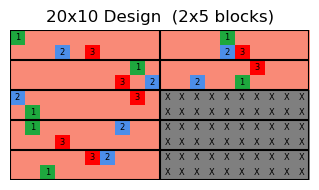

In [2]:
#define trialname
trialname="Testtrial_2021"
#define number of checktypes
numberofchecktypes=3
#define number of genotypes
numberofgenotypes=119
#define if only a design with checks should be generated (without genotypes): checks/all
designtype="all"
#define if entries shuffled (randomized) or not (sorted randomization for PM)
entries_randomized="yes"
#define name of list with entries and checks
templatename="Sample_data_Sudoku-augmented.xlsx"
#define color map
cmap_sudoku=ColorMap("Sudoku",[RGB(0.5,0.5,0.5),RGB(1, 0.933, 0.058),
        RGB(0.956, 0.164, 0.866),
        RGB(0.113, 0.666, 0.239),
        RGB(0.560, 0.368, 0.831),
        RGB(0.058, 0.733, 1),
        RGB(1,0,0),])
# define trial layout (x direction, y direction)
# we create here a design with 20 plots in x-direction and 10 plots in y-direction.
# one block contains 20 plots and goes along 2 y-coordinate points and 10 x-coordinate points.
C = get_configuration([10,10], [2,2,2,2,2], numberofchecktypes)
#display random distribution of checks within blocks (=classical augmented design)
initialize_checks_per_block!(C)
empty_plots!(C, 11:20,1:6)
show_configuration(C, zoom=0.2,cmap=cmap_sudoku)
savefig("initial_design_random_"*trialname*".pdf")

## 3) Define sudoku functions

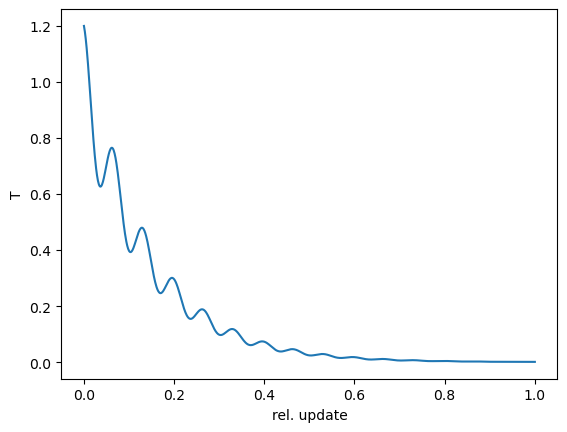

K_indiv (generic function with 1 method)

In [3]:
function mc_update!(C, T, updatemoves, K)
    K_alt = K(C)
    move  = rand(updatemoves)
    new_move!(move, C)
    apply_update!(C, move)
    K_neu = K(C)

    alpha = exp(-(K_neu - K_alt)/T)
    if rand() < alpha
        # akzeptieren
    else
        # nicht akzeptieren
        reverse_update!(C, move)
    end
    return nothing
end

beta(t) = 1*exp(-7*t) * (1 + 0.2*cos(t*30*pi))
tvals = 0:0.001:1
plot(tvals, beta.(tvals))
xlabel("rel. update")
ylabel("T")

## 4) Specialize update moves and costs

updates = [
    UpdateMoveNewCheckLabel(),
    #UpdateMoveInsertCheck(),
    #UpdateMoveRemoveCheck(),
    UpdateMoveSwapCheckCheck(),
    UpdateMoveSwapCheckGenotype()
]

function K_indiv(conf :: C) :: Float64 where {C <: CheckConfiguration}
    return  K_num_checks_equal_per_type(conf) +
            K_checks_per_type_per_block(conf, 1)*20+
            #K_neighbors_different_check_dmax_const(conf, 1, 0.5) +
            K_neighbors_different_check_functional(conf, d->0.5/(d^3)) +
            K_neighbors_same_check_functional(conf, d->1/(d^3))*12
end

## 4) Run sudoku

Optimizing Design ... 100%|█████████████████████████████| Time: 0:00:09


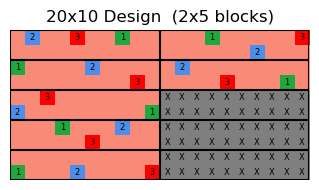

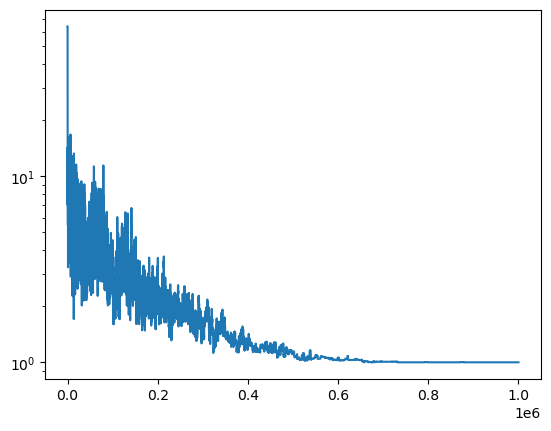

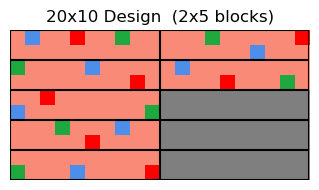

Kosten: 70.39559259259259 -> 7.414284722222222
perc_checks: 0.17647058823529413
genotypes: 119
checks:    21  (15.0%)
check (1): 7  (33.33%)
check (2): 7  (33.33%)
check (3): 7  (33.33%)


In [6]:
kosten = zeros(1000000)

#specify how many checks: (x*y)-no.genotypes - missing plots

#initialize_checks!(C, numberofchecks)

#number of genotypes
initialize_genotypes!(C, numberofgenotypes)
@showprogress "Optimizing Design ... " for i in 1:length(kosten)
    mc_update!(C, beta(i/length(kosten))*0.5, updates, K_indiv)
    kosten[i] = K_indiv(C)
end
kosten .-= minimum(kosten)
kosten .+= 1

#print things
println("Kosten: ",K_indiv(C)+kosten[1], " -> ", K_indiv(C)+kosten[end])
println("perc_checks: ",C.num_checks_total / (C.num_plots_total - C.num_checks_total))
println("genotypes: ",C.num_plots_total - C.num_checks_total)
println("checks:    ",C.num_checks_total, "  (", round(100*C.num_checks_total / C.num_plots_total, digits=2), "%)")
for i in 1:C.N
    println("check ($(i)): ",C.num_checks[i], "  (", round(100*C.num_checks[i] / C.num_checks_total, digits=2), "%)")    
end

show_configuration(C,cmap=cmap_sudoku,zoom=0.2)


figure()
plot(kosten)
yscale("log")


#save without check labels
show_configuration(C,check_labels=false,cmap=cmap_sudoku)
#savefig("final_sudoku_design_"*trialname*".png")
savefig("final_sudoku_design_"*trialname*".pdf")

## 6) Plot with Plant_Codes and write data to xlsx

## 5) Save field plan and design data

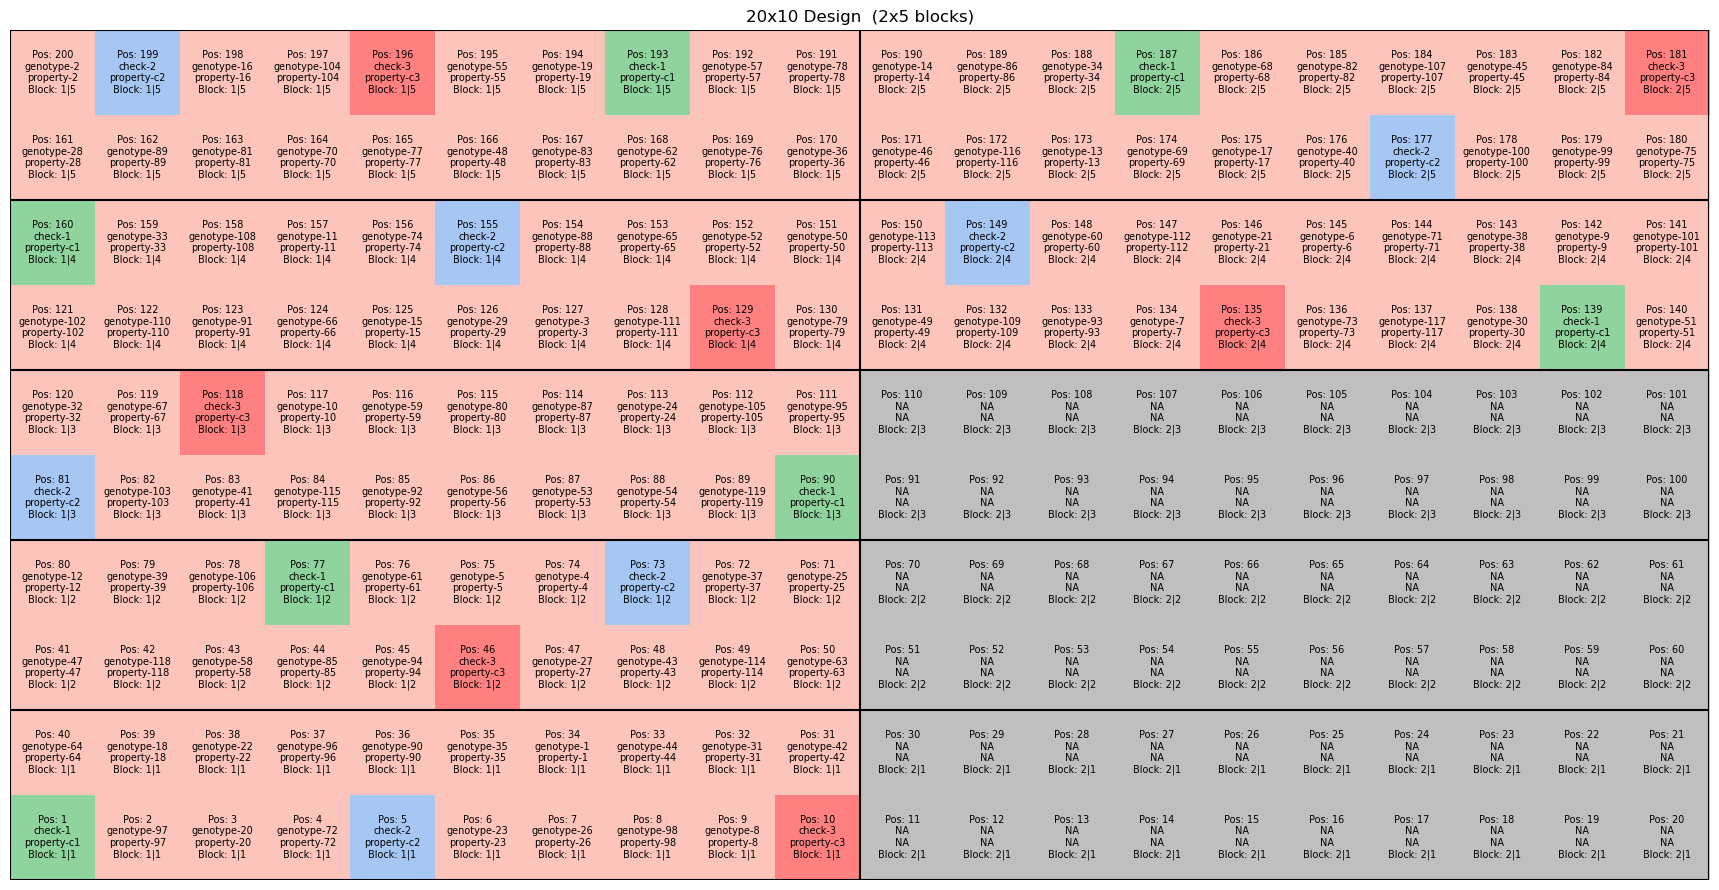

Entries are randomized 

In [7]:
#optional: load existing configuration
#load_configuration(C, "configuration_"*trialname*".txt")

#read in check data
checkdata = DataFrame(XLSX.readtable(templatename, "checks")...)
checknames=names(checkdata)
for i in 1:length(checknames)
    checkdata[!,Symbol(checknames[i])]=string.(collect(checkdata[!,Symbol(checknames[i])]))
end


#replace missing with NA
for col in eachcol(checkdata)
    replace!(col,missing => "NA")
end


if nrow(checkdata)!= numberofchecktypes
    println("Number of checks in csv not matching pre-defined checks!")
end


#depending on reading in additionally genotype file
if  designtype=="checks"
    print("Only checks were successfully read in, as specified")
    
elseif designtype=="all"
    #read in genotype data
    genotypedata = DataFrame(XLSX.readtable(templatename, "entries")...)
    genonames=names(genotypedata)
    for i in 1:length(checknames)
        genotypedata[!,Symbol(genonames[i])]=string.(collect(genotypedata[!,Symbol(genonames[i])]))
    end
    #replace missing with NA
    for col in eachcol(genotypedata)
        replace!(col,missing => "NA")
    end
    
    #catch if not matching number of genotypes
    if nrow(genotypedata)!= numberofgenotypes
        println("Number of genotypes in xlsx datafile not matching pre-defined number of genotypes!")
    end
    
    
    #shuffle genotypedata?
    if entries_randomized=="yes"
        genotypedata = genotypedata[shuffle(1:nrow(genotypedata)), :]
        genotypedata[!,:genotype]=string.(collect(genotypedata[!,:genotype]))
        print("Entries are randomized ")
        #print(genotypedata)

    elseif entries_randomized=="no"
        print("Entries are not randomized")
        #print(genotypedata)

    else
        print("Specify if genotypes are randomized or sorted with entries_randomized yes/no!")

    print("genotypes and checks are successfully read in")
    end
    
else
    print("Please specify designtype (checks/all)!")
        
end

#get the Plant label
#POS = get_POS_block_x(C,posempty=true) #if over 2 big blocks in splitted by x
POS = get_POS_coordinatewise(C,"x","left","lower","snake") #with robot

if designtype=="checks"
    L = get_Plant_Code_Label_allinfo_checksonly(C,POS,checkdata)
else
    L = get_Plant_Code_Label_allinfo(C,POS,genotypedata,checkdata)
end   

show_pos_and_labels_allinfo(C, POS, L, zoom=0.9,fontsize=7,alpha=0.5,cmap=cmap_sudoku)
savefig("final_sudoku_design_labels_"*trialname*".pdf")

In [8]:
#write file to xlsx
write_to_xlsx_allinfo(C.configuration,trialname,POS,L)

#save configuration
save_configuration(C, "configuration_"*trialname*".txt")
